<a href="https://colab.research.google.com/github/omarseleem92/flood_susceptibility_mapping/blob/main/RF_2m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the shapefile
df=gpd.read_file("/content/drive/MyDrive/RF_model_Flood_susceptibility/Merged_RF.shp")
df.head()

,Flooded,Aspect,CN,Curve,DEM,DTDrainage,DTRiver,DTRoad,Freq,Rainfall,Slope,TWI,geometry
0,0,0.957001,0.72,0.799850,0.412259,0.008363,0.054802,0.020846,0.466105,0.164432,0.016718,0.164849,POINT Z (382966.170 5814691.564 0.000)
1,0,0.470967,0.72,0.800776,0.401485,0.006973,0.078309,0.008858,0.627576,0.255468,0.091135,0.210387,POINT Z (383336.587 5814598.960 0.000)
2,0,0.942324,0.72,0.800335,0.412341,0.009118,0.104160,0.025825,0.705864,0.299589,0.067785,0.164357,POINT Z (383759.922 5814559.272 0.000)
3,0,0.994332,0.72,0.799277,0.439112,0.017643,0.094123,0.024873,0.729333,0.349291,0.025067,0.173485,POINT Z (384170.026 5814572.501 0.000)
4,0,0.076357,0.72,0.799542,0.418952,0.006865,0.090165,0.007769,0.734826,0.290722,0.010006,0.263441,POINT Z (384474.298 5814612.189 0.000)


In [ ]:
print(df.describe().T)  #Values need to be normalized before fitting. 

             count      mean       std       min       25%       50%  \
Flooded     3934.0  0.500000  0.500064  0.000000  0.000000  0.500000   
Aspect      3934.0  0.490472  0.299935  0.000000  0.230686  0.494488   
CN          3934.0  0.765074  0.054014  0.580000  0.720000  0.770000   
Curve       3934.0  0.799673  0.001490  0.784468  0.799365  0.799630   
DEM         3934.0  0.326524  0.053403  0.248286  0.283137  0.299461   
DTDrainage  3934.0  0.016004  0.025404  0.000000  0.004649  0.007977   
DTRiver     3934.0  0.069707  0.049146  0.000000  0.026939  0.061735   
DTRoad      3934.0  0.013727  0.013888  0.000000  0.005493  0.011653   
Freq        3934.0  0.523706  0.204706  0.079168  0.376067  0.540465   
Rainfall    3934.0  0.408745  0.202367  0.036162  0.221126  0.427292   
Slope       3934.0  0.025746  0.047224  0.000000  0.007828  0.014431   
TWI         3934.0  0.223363  0.069369  0.041362  0.173229  0.207372   

                 75%       max  
Flooded     1.000000  1.000000

In [ ]:
print(df.isnull().sum())
#df = df.dropna()

Flooded       0
Aspect        0
CN            0
Curve         0
DEM           0
DTDrainage    0
DTRiver       0
DTRoad        0
Freq          0
Rainfall      0
Slope         0
TWI           0
geometry      0
dtype: int64


In [ ]:
df = df.rename(columns={'Flooded':'Label'})
print(df.dtypes)

Label            int64
Aspect         float64
CN             float64
Curve          float64
DEM            float64
DTDrainage     float64
DTRiver        float64
DTRoad         float64
Freq           float64
Rainfall       float64
Slope          float64
TWI            float64
geometry      geometry
dtype: object


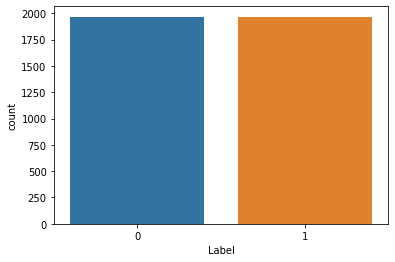

In [ ]:
#Understand the data 
sns.countplot(x="Label", data=df) #0 - Notflooded   B - Flooded

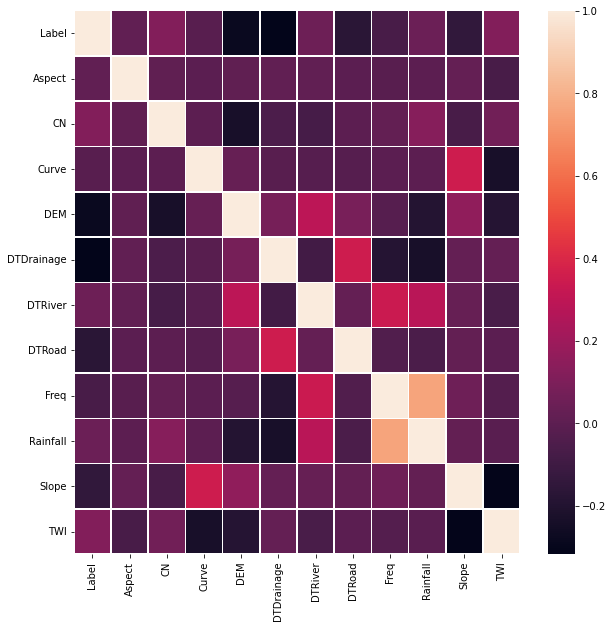

In [ ]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
#sns.heatmap(df.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(corrMatrix, annot=False, linewidths=.5, ax=ax)

In [ ]:
#Define the dependent variable that needs to be predicted (labels)
Y = df["Label"].values


In [ ]:
#Define the independent variables. Let's also drop Gender, so we can normalize other data
X = df.drop(labels = ["Label",'geometry'], axis=1) 
features_list = list(X.columns)  #List features so we can rank them later.
#from sklearn.preprocessing import normalize
#X = normalize(X, axis=1)

In [ ]:
X

,Aspect,CN,Curve,DEM,DTDrainage,DTRiver,DTRoad,Freq,Rainfall,Slope,TWI
0,0.957001,0.72,0.799850,0.412259,0.008363,0.054802,0.020846,0.466105,0.164432,0.016718,0.164849
1,0.470967,0.72,0.800776,0.401485,0.006973,0.078309,0.008858,0.627576,0.255468,0.091135,0.210387
2,0.942324,0.72,0.800335,0.412341,0.009118,0.104160,0.025825,0.705864,0.299589,0.067785,0.164357
3,0.994332,0.72,0.799277,0.439112,0.017643,0.094123,0.024873,0.729333,0.349291,0.025067,0.173485
4,0.076357,0.72,0.799542,0.418952,0.006865,0.090165,0.007769,0.734826,0.290722,0.010006,0.263441
...,...,...,...,...,...,...,...,...,...,...,...
3929,0.388047,0.72,0.799542,0.396425,0.012825,0.127760,0.009355,0.114188,0.092143,0.008882,0.232116
3930,0.142494,0.81,0.799806,0.371613,0.003333,0.164813,0.010987,0.318662,0.178534,0.013349,0.171602
3931,0.666879,0.81,0.799850,0.360921,0.003465,0.163731,0.011653,0.302372,0.198849,0.012433,0.173735
3932,0.982427,0.81,0.799057,0.369327,0.002950,0.171007,0.011123,0.299590,0.176342,0.004053,0.294096


In [ ]:
Y

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
#Split data into train, validation and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2,shuffle=True, random_state=42)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,shuffle=True, random_state=42)

In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42)

In [ ]:
# Train the model on training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
prediction = model.predict(X_test)

In [ ]:
prediction

array([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


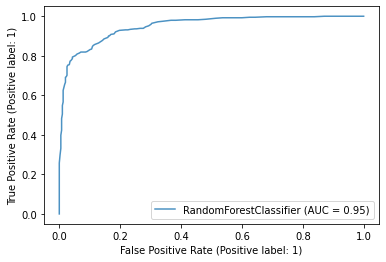

In [ ]:
from sklearn.metrics import plot_roc_curve

ax = plt.gca()
model_disp = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
plt.show()


In [ ]:
prediction_prob=model.predict_proba(X_test)

In [ ]:
prediction_prob

array([[0.05, 0.95],
       [0.88, 0.12],
       [0.33, 0.67],
       ...,
       [0.  , 1.  ],
       [0.64, 0.36],
       [0.  , 1.  ]])

In [ ]:
ls=prediction_prob[:,1]
ls.shape

(787,)

In [ ]:
from sklearn.metrics import classification_report
target_names=["Not Flooded","Flooded"]
print(classification_report(y_test, prediction, target_names=target_names))

              precision    recall  f1-score   support

 Not Flooded       0.84      0.89      0.87       395
     Flooded       0.89      0.83      0.86       392

    accuracy                           0.86       787
   macro avg       0.87      0.86      0.86       787
weighted avg       0.87      0.86      0.86       787



In [ ]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, prediction))


0.7280167694300268


In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction)
print(cm)

[[353  42]
 [ 65 327]]


In [ ]:
#importances = list(model_RF.feature_importances_)
feature_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)
print(feature_imp)

DEM           0.174355
DTDrainage    0.155009
DTRoad        0.123513
DTRiver       0.111450
Freq          0.098538
Rainfall      0.092725
TWI           0.060701
Curve         0.059290
Slope         0.045487
Aspect        0.039515
CN            0.039418
dtype: float64


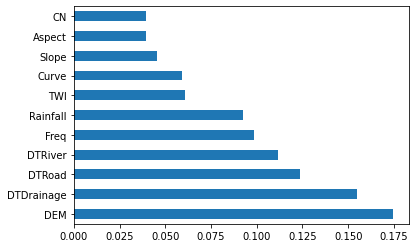

In [ ]:
feature_imp.plot.barh()

# Berlin

In [ ]:
!pip3 install pickle5
import pickle5 as pickle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
with open('/content/drive/MyDrive/RF_model_Flood_susceptibility/district_2_RF_2m.pkl', "rb") as fh:
  df = pickle.load(fh)


In [ ]:
df.head()

,VALUE,Aspect,CN,DEM,DTDrainage,DTRiver,DTRoad,Freq,Slope,TWI,Curve,Rainfall,geometry
0,34.580002,0.523138,0.81,0.282316,0.002574,0.033522,0.007252,0.510442,0.009681,0.215963,0.799423,0.623310,POINT (389893.708 5818773.972)
1,34.580002,0.510413,0.81,0.282224,0.003075,0.033429,0.007729,0.510442,0.005916,0.250464,0.799536,0.623310,POINT (389893.708 5818771.972)
2,34.580002,0.500386,0.81,0.282241,0.002925,0.033522,0.006224,0.510442,0.005322,0.229668,0.799595,0.623310,POINT (389895.708 5818771.972)
3,34.590000,0.292593,0.81,0.282350,0.003793,0.033244,0.009160,0.510741,0.016196,0.261043,0.799455,0.623741,POINT (389891.708 5818769.972)
4,34.570000,0.431156,0.81,0.282189,0.003590,0.033337,0.007593,0.510442,0.003926,0.328652,0.799533,0.623310,POINT (389893.708 5818769.972)


In [ ]:
X_hotspot0= df.drop(labels = ["geometry",'VALUE'], axis=1) 
X_hotspot0.head()

,Aspect,CN,DEM,DTDrainage,DTRiver,DTRoad,Freq,Slope,TWI,Curve,Rainfall
0,0.523138,0.81,0.282316,0.002574,0.033522,0.007252,0.510442,0.009681,0.215963,0.799423,0.623310
1,0.510413,0.81,0.282224,0.003075,0.033429,0.007729,0.510442,0.005916,0.250464,0.799536,0.623310
2,0.500386,0.81,0.282241,0.002925,0.033522,0.006224,0.510442,0.005322,0.229668,0.799595,0.623310
3,0.292593,0.81,0.282350,0.003793,0.033244,0.009160,0.510741,0.016196,0.261043,0.799455,0.623741
4,0.431156,0.81,0.282189,0.003590,0.033337,0.007593,0.510442,0.003926,0.328652,0.799533,0.623310


In [ ]:
cols=X.columns
cols

Index(['Aspect', 'CN', 'Curve', 'DEM', 'DTDrainage', 'DTRiver', 'DTRoad',
       'Freq', 'Rainfall', 'Slope', 'TWI'],
      dtype='object')

In [ ]:
X_hotspot0=X_hotspot0[cols]
X_hotspot0.head()

,Aspect,CN,Curve,DEM,DTDrainage,DTRiver,DTRoad,Freq,Rainfall,Slope,TWI
0,0.523138,0.81,0.799423,0.282316,0.002574,0.033522,0.007252,0.510442,0.623310,0.009681,0.215963
1,0.510413,0.81,0.799536,0.282224,0.003075,0.033429,0.007729,0.510442,0.623310,0.005916,0.250464
2,0.500386,0.81,0.799595,0.282241,0.002925,0.033522,0.006224,0.510442,0.623310,0.005322,0.229668
3,0.292593,0.81,0.799455,0.282350,0.003793,0.033244,0.009160,0.510741,0.623741,0.016196,0.261043
4,0.431156,0.81,0.799533,0.282189,0.003590,0.033337,0.007593,0.510442,0.623310,0.003926,0.328652


In [ ]:
print(X_hotspot0.isnull().sum())


Aspect        0
CN            0
Curve         0
DEM           0
DTDrainage    0
DTRiver       0
DTRoad        0
Freq          0
Rainfall      0
Slope         0
TWI           0
dtype: int64


In [ ]:
X_hotspot0 = X_hotspot0.dropna()

In [ ]:
df=df.dropna()

In [ ]:
prediction_prob=model.predict_proba(X_hotspot0)

In [ ]:
prediction_prob

array([[0.1 , 0.9 ],
       [0.08, 0.92],
       [0.09, 0.91],
       ...,
       [0.87, 0.13],
       [0.9 , 0.1 ],
       [0.87, 0.13]])

In [ ]:
ls_hotspot0=prediction_prob[:,1]
ls_hotspot0

array([0.9 , 0.92, 0.91, ..., 0.13, 0.1 , 0.13])

In [ ]:
df['FSM']=ls_hotspot0
df.head()


,VALUE,Aspect,CN,DEM,DTDrainage,DTRiver,DTRoad,Freq,Slope,TWI,Curve,Rainfall,geometry,FSM
0,34.580002,0.523138,0.81,0.282316,0.002574,0.033522,0.007252,0.510442,0.009681,0.215963,0.799423,0.623310,POINT (389893.708 5818773.972),0.90
1,34.580002,0.510413,0.81,0.282224,0.003075,0.033429,0.007729,0.510442,0.005916,0.250464,0.799536,0.623310,POINT (389893.708 5818771.972),0.92
2,34.580002,0.500386,0.81,0.282241,0.002925,0.033522,0.006224,0.510442,0.005322,0.229668,0.799595,0.623310,POINT (389895.708 5818771.972),0.91
3,34.590000,0.292593,0.81,0.282350,0.003793,0.033244,0.009160,0.510741,0.016196,0.261043,0.799455,0.623741,POINT (389891.708 5818769.972),0.92
4,34.570000,0.431156,0.81,0.282189,0.003590,0.033337,0.007593,0.510442,0.003926,0.328652,0.799533,0.623310,POINT (389893.708 5818769.972),0.93


In [ ]:
! pip install geocube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import geocube
from geocube.api.core import make_geocube

geo_grid = make_geocube(
    vector_data=df,
    measurements=['FSM'],
    resolution=(-2, 2)
)

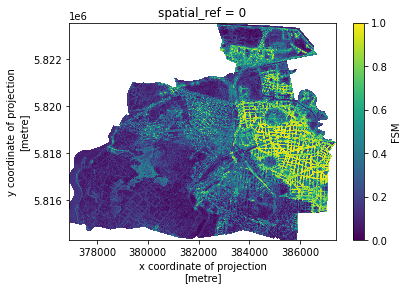

In [ ]:
geo_grid.FSM.plot()

In [ ]:
geo_grid.FSM.rio.to_raster("FSM.tif")
